In [1]:
import os
import glob
import pandas as pd

- **EAII dataset preparation**

In [2]:
eaii_datset_path = "/Users/aic/Downloads/Annotated_coffee_data_march/eaii_coffee_arabica/segmentation"

In [3]:
dataset_df = pd.read_csv(os.path.join(eaii_datset_path,"dataset.csv"))
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   images_names  887 non-null    object
 1   mask_names    887 non-null    object
dtypes: object(2)
memory usage: 14.0+ KB


- Visualize sample data

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols > 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

    

In [5]:
def read_image():
    sample = dataset_df.sample(1).values[0]
    im = cv2.imread(os.path.join(eaii_datset_path,sample[1]))
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    return im

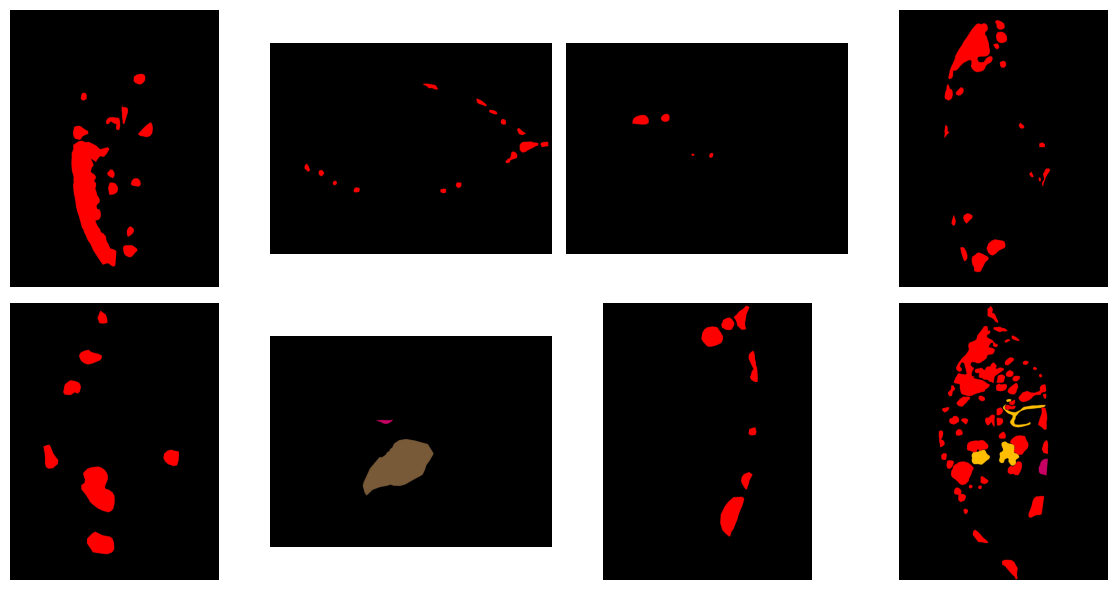

In [6]:
images = [read_image() for _ in range(8)]
plot_image_grid(images)

- Prepare a pytorch dataset

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF

In [8]:
from typing import Tuple
import random

class CoffeeArabicaDataset(Dataset):
    def __init__(self,df:pd.DataFrame,dataset_path:str,target_size:Tuple = (256,256),train:bool = True) -> None:
        super().__init__()
        self.df = df
        self.dataset_path = dataset_path
        self.train = train
        self.target_size = target_size

    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, index) -> torch.Tensor:
        # get image and mask file paths
        image_filename = self.df.iloc[index,0]
        mask_filename = self.df.iloc[index,1]
        # read image and masks
        image = cv2.imread(os.path.join(self.dataset_path,image_filename))
        mask = cv2.imread(os.path.join(self.dataset_path,mask_filename))
        # Convert image to rgb
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # convert mask to gray and threshold
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        _,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
        # Convert image and mask to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        # resize image and mask to the target size
        image  = TF.resize(image,self.target_size)
        mask = TF.resize(mask,self.target_size)
        # add the same random rotation to the image and mask
        if self.train:
            # random rotate
            if random.random() < 0.5:
                angle = random.randint(-20,20)
                translate = (0.2,0.2)
                shear = random.randint(-10,10)
                scale = 1

                image = TF.affine(image,angle,translate,scale,shear,fill=(0, 0, 0))
                mask =TF.affine(mask,angle,translate,scale,shear,fill=0)
                
        return image,mask


- Load Elunet model and weights

In [9]:
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.elunet.elunet import ELUnet 


In [10]:
device = torch.device("cpu")
elunet_model = ELUnet(3,1,16)

In [11]:
def get_model():
    model = elunet_model.to(device)
    model.load_state_dict(torch.load("../coffee_arabica_weights/elunet_symptom_leaf_2023-03-05.pth"))
    count = 0
    for child in model.children():
        if count > 15:
            for param in child.parameters():
                param.requires_grad = False
        count +=1
    return model

- Cross validation

In [12]:
# Define the dice loss function
# define dice coefficient and dice loss function
def calc_dice_loss(preds:torch.Tensor,targets:torch.Tensor):
    def dice_coefficient(preds:torch.Tensor,targets:torch.Tensor):
        smooth = 1.0
        assert preds.size() == targets.size()
        
        iflat = preds.contiguous().view(-1)
        tflat = targets.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return 1.0 - dice_coefficient(preds,targets)

In [13]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
# ++++++++++++++++++++++++++++++++++++++++
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 50
# ++++++++++++++++++++++++++++++++++++++++

CURRENT_VAL_LOSS = 0
CURRENT_EPOCH = 0

def early_stopping(val_loss,epoch,patience=10,min_delta=0.01):
        """ Helper method for model training early stopping """
        
        global CURRENT_VAL_LOSS
        global CURRENT_EPOCH

        if val_loss < CURRENT_VAL_LOSS and CURRENT_VAL_LOSS - val_loss >= min_delta:
            # Val loss improved -> save model
            print(f"[Info] Val loss improved from {CURRENT_VAL_LOSS} to {val_loss}")
            #save_model(model)
            CURRENT_VAL_LOSS = val_loss
            CURRENT_EPOCH = epoch
            return False
        if val_loss >= CURRENT_VAL_LOSS and epoch - CURRENT_EPOCH >= patience:
            ## Stop training
            return True
        return False

def train(model,train_loader):
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    progress_bar = tqdm(train_loader,total=len(train_loader))
    
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = []
        for i,data in enumerate(progress_bar):
            image,mask = data
            image = image.to(device)
            mask = mask.to(device)
            # get predicition
            mask_pred = model(image)

            loss = calc_dice_loss(mask_pred,mask)
            # empty gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            progress_bar.set_description(f"Epoch {epoch+1}/{EPOCHS}")
            progress_bar.set_postfix(loss = np.mean(epoch_loss),dice = 1 - np.mean(epoch_loss))
            progress_bar.update()

        if early_stopping(np.mean(epoch_loss),epoch):
            print(f"[INFO] Early Stopping")
            print(f"Stopped!!")



In [14]:
@torch.no_grad()
def evaluate(model,val_loader):
    progress_bar = tqdm(val_loader,total=len(val_loader))

    val_loss = []
    for i,data in enumerate(progress_bar):
        image,mask = data
        image = image.to(device)
        mask = mask.to(device)
        # get predicition
        mask_pred = model(image)

        loss = calc_dice_loss(mask_pred,mask)

        val_loss.append(loss.item())
        progress_bar.set_description(f"Evaluating")
        progress_bar.set_postfix(eval_loss = np.mean(val_loss),eval_dice = 1 - np.mean(val_loss))
        progress_bar.update()
        
    return np.mean(val_loss)

In [15]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

def cross_validate(k = 5):
    # Define the cross-validation splitter
    kf = KFold(n_splits=k,shuffle=True)

    cross_val_scores = []
    best_model = None

    # Loop over each fold
    for fold,(train_idx,val_idx) in enumerate(kf.split(dataset_df)):
        print(f'Fold {fold + 1}')
        model = get_model().to(device)

        # Define your training and validation sets for this fold
        train_df = dataset_df.iloc[train_idx]
        val_df = dataset_df.iloc[val_idx]
        # define the dataset
        train_dataset = CoffeeArabicaDataset(train_df,eaii_datset_path)
        val_dataset = CoffeeArabicaDataset(train_df,eaii_datset_path,train=False)

        # Define the data loaders for this fold
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        # Train and evaluate model
        train(model,train_loader)

        fold_loss = evaluate(model,val_loader)
        if len(cross_val_scores):
            if fold_loss > np.max(cross_val_scores):
                best_model = model
        cross_val_scores.append(fold_loss)
    return best_model



In [17]:
from datetime import datetime
def save_model(self,model):
    date_postfix = datetime.now().strftime("%Y-%m-%d")
    model_name = f'arabica_symptom_{date_postfix}.pth'
    save_path = "../coffee_arabica_weights"
    
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    else:
        print(f"[INFO] Saving model to {os.path.join(save_path,model_name)}")
        torch.save(model.state_dict(),os.path.join(save_path,model_name))

In [ ]:
best_model = cross_validate(5)

save_model(best_model)

